https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [39]:
import warnings
warnings.filterwarnings('ignore')

### In Depth: Parameter tuning for Random Forest

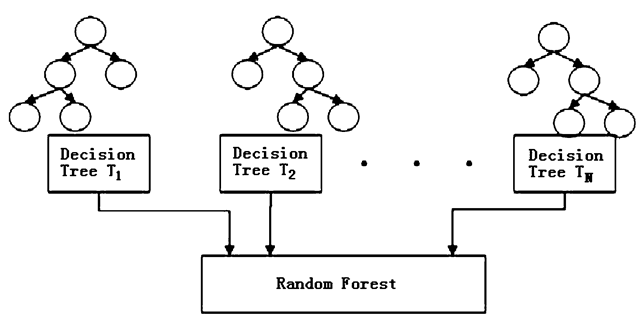

In [2]:
## This is for an `png` image
from IPython.display import Image
fig = Image(filename=('RF.png'))
fig

* In this post we will explore the most important parameters of Random Forest and how they impact our model in term of overfitting and underfitting.

* A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

### Load train data

In [5]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("RF_train.csv")
print (train.shape)

(891, 12)


In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Move the reponse variable "Survived" to the front of the table
front = train['Survived']
train.drop(labels=['Survived'], axis=1,inplace = True)
train.insert(0, 'Survived', front)
train.head()

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Check for missing values

In [8]:
#Checking for missing data
train.isnull().sum()

Survived         0
PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum()], axis=1, keys=['Train'])
NAs[NAs.sum(axis=1) > 0]

,Train
Age,177
Cabin,687
Embarked,2


### Imputing missing values

In [10]:
# Filling missing Age values with MEAN
train['Age'] = train['Age'].fillna(train['Age'].mean())

In [11]:
# Filling missing Embarked values with most common value: MODE
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [12]:
#Checking for missing data
train.isnull().sum()

Survived         0
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

We will remove ‘Cabin’, ‘Name’ and ‘Ticket’ columns as they require some processing to extract useful features

In [13]:
train.pop('Cabin')
train.pop('Name')
train.pop('Ticket')
train.shape

(891, 9)

‘Pclass’ is a categorical feature so we convert its values to strings

In [14]:
train['Pclass'] = train['Pclass'].apply(str)

### Let’s perform a basic one hot encoding of categorical features


In [15]:
train.Pclass.unique()
# Pclass: Pclass_1, Pclass_2, Pclass_3

array(['3', '1', '2'], dtype=object)

In [16]:
train.Sex.unique()
# Sex: Sex_female, Sex_male

array(['male', 'female'], dtype=object)

In [17]:
train.Embarked.unique()
# Embarked: Embarked_C, Embarked_Q, Embarked_S

array(['S', 'C', 'Q'], dtype=object)

In [18]:
# Getting Dummies from all other categorical vars
for col in train.dtypes[train.dtypes == 'object'].index:
    for_dummy = train.pop(col)
    train = pd.concat([train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

train.head()

,Survived,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,1,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,2,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,4,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,5,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [19]:
train.shape

(891, 14)

In [20]:
labels = train.pop('Survived')

### For testing, we choose to split our data to 75% train and 25% for test


In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.25)

In [22]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(668, 13)
(668,)
(223, 13)
(223,)


### Let’s first fit a random forest with " Default Parameters " to get a baseline idea of the performance

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf = RandomForestClassifier()

rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

c:\users\bhairab.singh.soren\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


* We will use AUC (Area Under Curve) as the evaluation metric. 
* Our target value is binary so it’s a binary classification problem. 
* AUC is a good way for evaluation for this type of problems.

In [25]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7788624070317782

#### N_estimators

* n_estimators represents the number of trees in the forest. 
* Usually the higher the number of trees the better to learn the data. 
* However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

In [26]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
    # initialize the model
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    
    # fit the model
    rf.fit(x_train, y_train)
    
    # prediction for y_train
    train_pred = rf.predict(x_train)
    
    # ROC_AUC metrics
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    # prediction for x_test
    y_pred = rf.predict(x_test)
    
    # ROC_AUC metrics
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

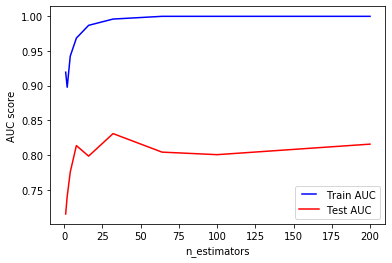

In [31]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()


We can see that for our data, we can stop at 32 trees as increasing the number of trees decreases the test performance.

#### max_depth

* max_depth represents the depth of each tree in the forest. 
* The deeper the tree, the more splits it has and it captures more information about the data. 
* We fit each decision tree with depths ranging from 1 to 32 and plot the training and test errors.

In [40]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    
    rf.fit(x_train, y_train)
    
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

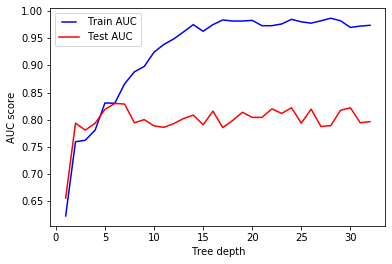

In [42]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

We see that our model overfits for large depth values. The trees perfectly predicts all of the train data, however, it fails to generalize the findings for new data